Imports!

In [1]:
%matplotlib inline

import h5py

from keras.optimizers import SGD
from keras.utils.visualize_util import to_graph

from IPython.display import SVG

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

import train
from train import infer_sizes
from models import vggnet16_regressor_model

Using gpu device 2: Tesla K80 (CNMeM is enabled)
/home/sam/repos/joint-regressor/keras/env/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Using Theano backend.


Now load up our data H5 and grab some trained weights for our model.

In [2]:
# Load data and get a model
train_h5_path = '../cache/train-patches-mpii-fixed/samples-000001.h5'
val_h5_path = train_h5_path.replace('train', 'val')
train_h5 = h5py.File(train_h5_path, 'r')
val_h5 = h5py.File(val_h5_path, 'r')
images = train_h5['images']
joints = train_h5['joints']
flow = train_h5['flow']
val_images, val_flow, val_joints = val_h5['images'], val_h5['flow'], val_h5['joints']
input_shape, reg_outs, class_outs = infer_sizes(train_h5_path)
sgd = SGD(lr=0.0001, nesterov=True, momentum=0.9)
model = vggnet16_regressor_model(input_shape, reg_outs, sgd, 'glorot_normal')
model.load_weights('../cache/keras-checkpoints/model-iter-960-r311060.h5')

Start by doing a basic visualisation of our model and inspecting the shape of our data.

# Data shapes
images: (232564, 6, 224, 224)
flow: (232564, 2, 224, 224)
joints: (232563, 12)

# Network


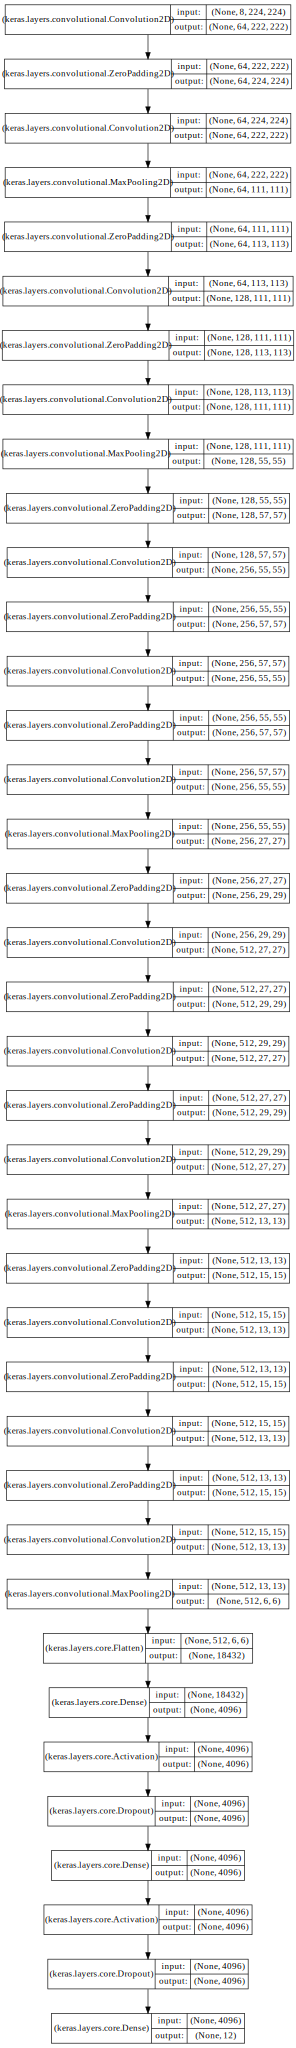

In [3]:
print '# Data shapes'
print 'images:', images.shape
print 'flow:', flow.shape
print 'joints:', joints.shape
print
print '# Network'
SVG(to_graph(model, show_shape=True).create(prog='dot', format='svg'))

Now write some functions to look at our data and also a few utilities for doing forward prop. These will be useful for inspecting activations and gradients, as well as verifying that I've written what I wanted to write to the file.

Note that some of these images will look weird because they've been padded (where necessary) with their edge pixel values. This is true of the flow as well.

Datum 24533


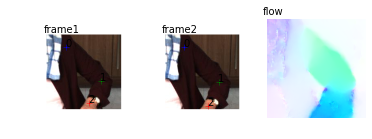

Datum 55946


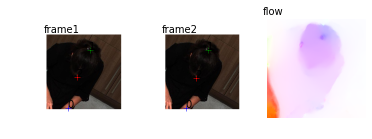

Datum 48502


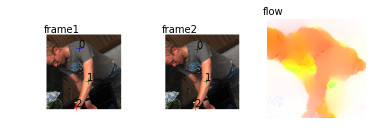

In [4]:
def _reshape_im(im):
    # images are stored channels-first, but numpy expects
    # channels-last
    return np.transpose(im, axes=(1, 2, 0))

def _vis_flow(flow):
    # clean visualisation of flow with angle of movement as
    # hue, magnitude as saturation and a constant V of 1
    x, y = flow
    # normed-log makes things stand out quite a bit
    mags = np.log(np.sqrt(x**2 + y**2) + 1)
    norm_mags = mags / max(mags.flatten())
    angles = (np.arctan2(x, y) + np.pi) / (2 * np.pi)
    ones = np.ones_like(angles)
    hsv = np.stack((angles, norm_mags, ones), axis=2)
    return hsv_to_rgb(hsv)

def _label_to_coords(label):
    return label.reshape((-1, 2))

def _plot_coords(coords):
    # plot a label corresponding to a flattened joint vector
    for idx, coord in enumerate(coords):
        plt.plot(coord[0], coord[1], marker='+')
        plt.text(coord[0], coord[1], str(idx))

def show_datum(image, flow, label=None):
    # First frame
    im1 = _reshape_im(image[:3])
    plt.subplot(131)
    plt.imshow(im1)
    plt.axis('off')
    plt.text(-10, -10, 'frame1')
    
    if label is not None:
        coords = _label_to_coords(label)
        first_coords = coords[:len(coords)//2]
        _plot_coords(first_coords)
    
    # Second frame
    im2 = _reshape_im(image[3:6])
    plt.subplot(132)
    plt.imshow(im2)
    plt.axis('off')
    plt.text(-10, -10, 'frame2')
    
    if label is not None:
        second_coords = coords[len(coords)//2:]
        _plot_coords(second_coords)
    
    # Optical flow
    im_flow = _vis_flow(flow)
    plt.subplot(133)
    plt.imshow(im_flow)
    plt.axis('off')
    plt.text(-10, -10, 'flow')
    plt.show()

for i in np.random.permutation(len(joints))[:3]:
    print 'Datum', i
    show_datum(images[i], flow[i], joints[i])

Now we can try evaluating the CNN on some of our training and evaluation data, just to see whether it's learning anything useful.

# Validation images
Validation datum 413


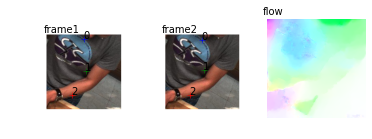

Validation datum 904


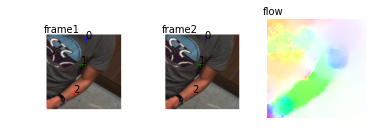

Validation datum 1209


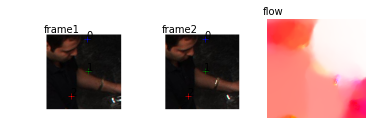

Validation datum 832


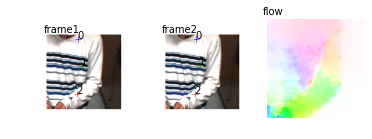

Validation datum 1051


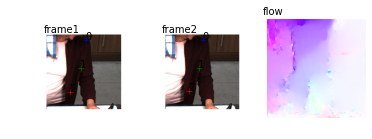

Validation datum 1011


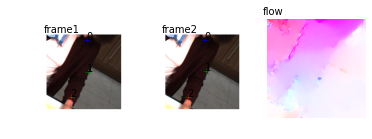

Validation datum 1229


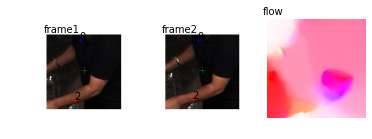

Validation datum 1225


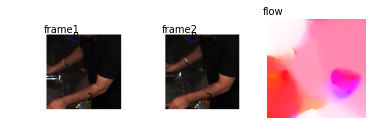

Validation datum 979


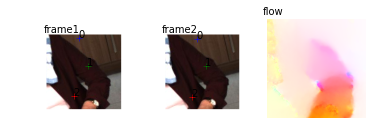

Validation datum 550


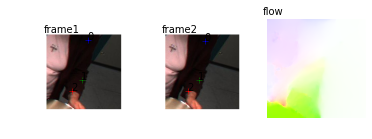

# Training images
Training datum 39187


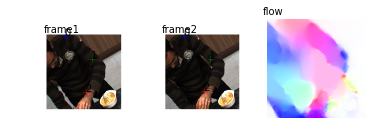

Training datum 230188


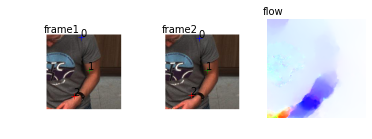

Training datum 159806


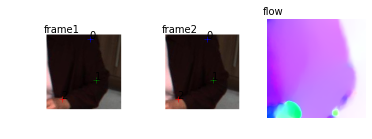

Training datum 94861


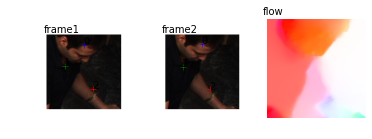

Training datum 69501


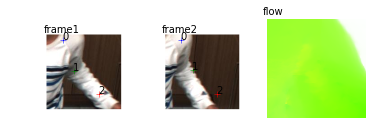

In [7]:
def evaluate_on_datum(image, flow):
    # NOTE: Need to stack data correctly and subtract flow
    stacked = np.concatenate((image.astype('float32'), flow.astype('float32')), axis=0)
    mp = train.read_mean_pixel('../cache/mean_pixel.mat')
    stacked -= mp.reshape((len(mp), 1, 1))
    return model.predict(stacked.reshape((1,) + stacked.shape))[0]

print('# Validation images')
for i in np.random.permutation(len(val_joints))[:10]:
    print 'Validation datum', i
    pred_joints = evaluate_on_datum(val_images[i], val_flow[i])
    show_datum(images[i], flow[i], pred_joints)
    
print('# Training images')
for i in np.random.permutation(len(joints))[:5]:
    print 'Training datum', i
    pred_joints = evaluate_on_datum(images[i], flow[i])
    show_datum(images[i], flow[i], pred_joints)